In [1]:
#Define libraries
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, BatchNormalization, Flatten
from sklearn.model_selection import KFold
from keras.utils import multi_gpu_model
#from sklearn.cross_validation import StratifiedKFold
from contextlib import redirect_stdout

from keras.utils import plot_model
from IPython.display import Image
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
from IPython.display import SVG
import datetime
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import EarlyStopping, ModelCheckpoint

gpu_options = tf.GPUOptions(allow_growth=True)
sess =tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
tf.keras.backend.set_session(sess)


NBname='_12FC'
%matplotlib inline

# =======
# 441PANet2
# np.random.seed(100)
# kernel_len 25
# half (3,6, 9, 12, 15) 
# decay=0.0000125
# dropout 0.25
# # # diff b/w 441PANet2 & 10p121PANet2
# FC 2x12
# patience 10
# epochs 50
# lr=0.00000625
# # # diff b/w 10p121PANet2 & 12FC
# no ES
# =======

Using TensorFlow backend.


In [2]:
SMALL_SIZE = 10
MEDIUM_SIZE = 15
BIGGER_SIZE = 18

# font = {'family' : 'monospace',
#         'weight' : 'bold',
#         'size'   : 'larger'}

#plt.rc('font', **font)  # pass in the font dict as kwargs
plt.rc('font', size=MEDIUM_SIZE,family='normal',weight='normal')          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE,)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE,)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE,titleweight='bold')  # fontsize of the figure title
#plt.rc('xtick', labelsize=15) 
#plt.rc('ytick', labelsize=15) 

In [3]:
print(str(datetime.datetime.now()))

2019-06-07 18:05:14.389638


In [4]:
def save_models(mod, last):
  for i in range(len(mod)):
    name=str(i+1)+last
    mod[i].model.save(name)
    

In [5]:
def plot_perform2(mod, metric, last,ttl):
  #plt.figure(figsize=(13,13))
  plt.figure(figsize=(11,11))  
  for i in range(len(mod)):
    name=str(i+1)
    val = plt.plot(mod[i].epoch, mod[i].history['val_'+metric],
                       '--', label=name.title()+'_Val',linewidth=1.5)        
    plt.plot(mod[i].epoch, mod[i].history[metric],
                 color=val[0].get_color(), label=name.title()+'_Train',linewidth=1.2)

  plt.xlabel('Epochs')
  plt.ylabel(metric.replace('_',' ').title())
  plt.ylabel(metric.title())
  plt.title(ttl)
  plt.legend(loc='best')

  plt.xlim([0,max(mod[i].epoch)])
  figname=metric+last+'.png'
  plt.savefig(figname,dpi=500)


In [6]:
def create_model0(shape1):

    model0 = Sequential()

    model0.add(Conv1D(3, 25, strides=1,padding='same',activation='relu', batch_input_shape=(None,shape1,1)))
    model0.add(BatchNormalization())
    model0.add(Conv1D(3, 25, strides=1,padding='same',activation='relu'))
    model0.add(MaxPooling1D(2))
    
    model0.add(Conv1D(6, 25, strides=1,padding='same',activation='relu'))
    model0.add(BatchNormalization())
    model0.add(Conv1D(6, 25, strides=1,padding='same',activation='relu'))
    model0.add(MaxPooling1D(2))
    
    model0.add(Conv1D(9, 25, strides=1,padding='same',activation='relu'))
    model0.add(BatchNormalization())
    model0.add(Conv1D(9, 25, strides=1,padding='same',activation='relu'))
    model0.add(MaxPooling1D(2))

    model0.add(Conv1D(12, 25, strides=1,padding='same',activation='relu'))
    model0.add(BatchNormalization())
    model0.add(Conv1D(12, 25, strides=1,padding='same',activation='relu'))
    model0.add(MaxPooling1D(2))

    model0.add(Conv1D(15, 25, strides=1,padding='same',activation='relu'))
    model0.add(BatchNormalization())
    model0.add(Conv1D(15, 25, strides=1,padding='same',activation='relu'))
    model0.add(MaxPooling1D(2))

    model0.add(Flatten())
    model0.add(Dense(12, activation='relu'))
    model0.add(Dense(12, activation='relu'))
    #model0.add(Dense(8, activation='relu'))
    model0.add(Dropout(0.25))
    model0.add(Dense(2, activation='softmax'))

    return model0



In [7]:
%%time

batch_size = 10
N_epochs = 50
N_folds=4
np.random.seed(100)
kf = KFold(n_splits=N_folds, shuffle=False)

# fm='train_x.npy'
# fl='train_y.npy'
# data=np.load(os.path.abspath(fm))
# dlabels=np.load(os.path.abspath(fl))

rm='res_x.npy'
rl='res_y.npy'
rdata=np.load(os.path.abspath(rm))
rlabels=np.load(os.path.abspath(rl))

sm='sen_x.npy'
sl='sen_y.npy'
sdata=np.load(os.path.abspath(sm))
slabels=np.load(os.path.abspath(sl))

# =================
# Do once!
# =================

sen_batch = np.random.RandomState(seed=45).permutation(sdata.shape[0])
bins = np.linspace(0, 200, 41)
digitized = np.digitize(sen_batch, bins,right=False)

# ================

#adamax=keras.optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
#adam=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#default reco
#nadam=keras.optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)

# sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
# adadelta=keras.optimizers.Adadelta(lr=1, rho=0.95, epsilon=None, decay=0.0)
# rmsp=keras.optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=None, decay=0.0)
# adagrad=keras.optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0

i=0
adamax=[]
callbacks = [EarlyStopping(monitor='val_loss', patience=10),
             ModelCheckpoint(filepath='best_model'+NBname+'.h5', monitor='val_loss', save_best_only=True)]


for train_idx_k, val_idx_k in kf.split(rdata):
    print ("Running Fold", i+1, "/", N_folds)
    
    # ===============================
    # select train
    # ===============================
    
    s_train_x=sdata[np.isin(digitized,train_idx_k+1)]
    s_train_y=slabels[np.isin(digitized,train_idx_k+1)]
    r_train_x=np.concatenate((rdata[train_idx_k],rdata[train_idx_k],rdata[train_idx_k],rdata[train_idx_k],rdata[train_idx_k]))
    r_train_y=np.concatenate((rlabels[train_idx_k],rlabels[train_idx_k],rlabels[train_idx_k],rlabels[train_idx_k],rlabels[train_idx_k]))

    # ===============================
    # select val
    # ===============================
    
    s_val_x=sdata[np.isin(digitized,val_idx_k+1)]
    s_val_y=slabels[np.isin(digitized,val_idx_k+1)]
    
    r_val_x=np.concatenate((rdata[val_idx_k],rdata[val_idx_k],rdata[val_idx_k],rdata[val_idx_k],rdata[val_idx_k]))
    r_val_y=np.concatenate((rlabels[val_idx_k],rlabels[val_idx_k],rlabels[val_idx_k],rlabels[val_idx_k],rlabels[val_idx_k]))

    # ===============================
    # concatenate F_train/val_x/y
    # ===============================

    f_train_x, f_train_y = np.concatenate((s_train_x,r_train_x)), np.concatenate((s_train_y,r_train_y)) 
#     train_shuf_idx = np.random.permutation(f_train_x.shape[0])
#     F_train_x, F_train_y = f_train_x[train_shuf_idx], f_train_y[train_shuf_idx]

    f_val_x, f_val_y = np.concatenate((s_val_x,r_val_x)), np.concatenate((s_val_y,r_val_y))
#     val_shuf_idx = np.random.permutation(f_val_x.shape[0])
#     F_val_x, F_val_y = f_val_x[val_shuf_idx], f_val_y[val_shuf_idx]

    # ===============================
    # shuffle just because we can?
    # ===============================
    
    train_shuf_idx = np.random.permutation(f_train_x.shape[0])
    x_train_CV, y_train_CV = f_train_x[train_shuf_idx], f_train_y[train_shuf_idx]
    
    val_shuf_idx = np.random.permutation(f_val_x.shape[0])
    x_val_CV, y_val_CV = f_val_x[val_shuf_idx], f_val_y[val_shuf_idx] 

    # ===============================
    # clear and create empty model 
    # ===============================
    
    model0 = None # Clearing the NN.    
    model0 = create_model0(rdata.shape[1])
    
#    x_train_CV, y_train_CV, = data[train_idx_k], dlabels[train_idx_k]
#    x_val_CV, y_val_CV, = data[val_idx_k], dlabels[val_idx_k]

#     parallel_model = None    
#     parallel_model = multi_gpu_model(model0, gpus=2)
#     #default
#     #parallel_model.compile(optimizer=keras.optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0),
#     parallel_model.compile(optimizer=keras.optimizers.Adamax(lr=0.004, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.005),
#                              loss='categorical_crossentropy',
#                              metrics=['accuracy','categorical_crossentropy'])
#     model0_adamax = parallel_model.fit(x_train_CV, y_train_CV,
#                                           epochs=N_epochs,
#                                           batch_size=batch_size, 
#                                           validation_data=(x_val_CV,y_val_CV),
#                                           verbose=1)

    #default
    #parallel_model.compile(optimizer=keras.optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0),
    model0.compile(optimizer=keras.optimizers.Adamax(lr=0.00000625, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0000125),
                             loss='categorical_crossentropy',
                             metrics=['accuracy','categorical_crossentropy'])
    model0_adamax = model0.fit(x_train_CV, y_train_CV,
                                          epochs=N_epochs,
                                          batch_size=batch_size, 
                                          validation_data=(x_val_CV,y_val_CV),
                                          verbose=2)#,callbacks=callbacks)

    adamax.append(model0_adamax)           
    i=i+1

Running Fold 1 / 4
Train on 300 samples, validate on 100 samples
Epoch 1/50
 - 21s - loss: 0.6505 - acc: 0.6533 - categorical_crossentropy: 0.6505 - val_loss: 0.6023 - val_acc: 0.6800 - val_categorical_crossentropy: 0.6023
Epoch 2/50
 - 15s - loss: 0.5514 - acc: 0.7467 - categorical_crossentropy: 0.5514 - val_loss: 0.5720 - val_acc: 0.7200 - val_categorical_crossentropy: 0.5720
Epoch 3/50
 - 16s - loss: 0.5225 - acc: 0.7433 - categorical_crossentropy: 0.5225 - val_loss: 0.5464 - val_acc: 0.7500 - val_categorical_crossentropy: 0.5464
Epoch 4/50
 - 15s - loss: 0.5141 - acc: 0.7733 - categorical_crossentropy: 0.5141 - val_loss: 0.5576 - val_acc: 0.7400 - val_categorical_crossentropy: 0.5576
Epoch 5/50
 - 15s - loss: 0.4841 - acc: 0.7733 - categorical_crossentropy: 0.4841 - val_loss: 0.5699 - val_acc: 0.7900 - val_categorical_crossentropy: 0.5699
Epoch 6/50
 - 15s - loss: 0.4599 - acc: 0.7933 - categorical_crossentropy: 0.4599 - val_loss: 0.5414 - val_acc: 0.7800 - val_categorical_crossent

/home/uu_bio_amrdl/dprasad/miniconda3/envs/TFgpu/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


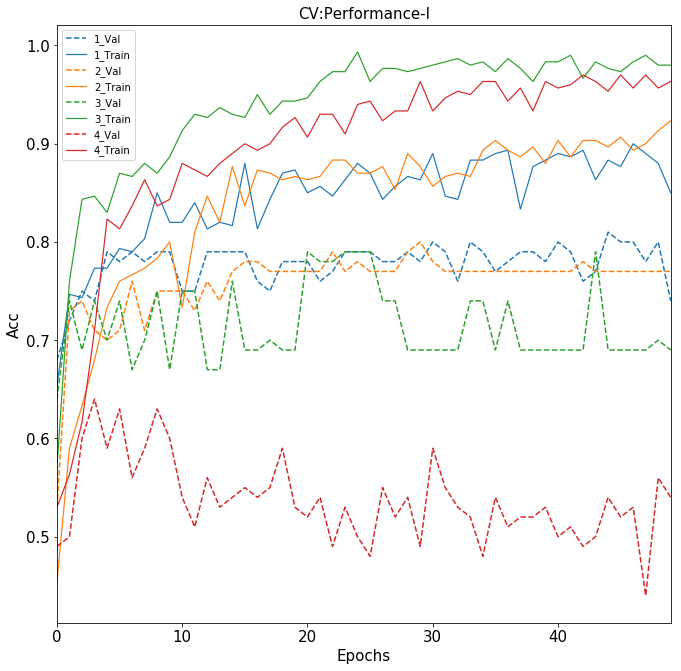

In [8]:
plot_perform2(adamax,'acc',NBname,'CV:Performance-I')

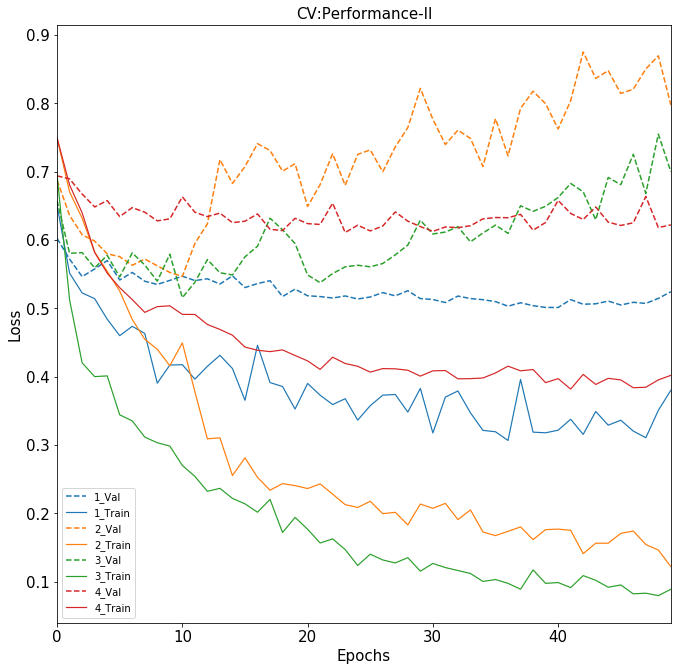

In [9]:
plot_perform2(adamax,'loss',NBname,'CV:Performance-II')

In [10]:
with open('summary'+NBname+'.txt', 'w') as f:
    with redirect_stdout(f):
        model0.summary()

In [11]:
model0.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_31 (Conv1D)           (None, 1152012, 3)        78        
_________________________________________________________________
batch_normalization_16 (Batc (None, 1152012, 3)        12        
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 1152012, 3)        228       
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 576006, 3)         0         
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 576006, 6)         456       
_________________________________________________________________
batch_normalization_17 (Batc (None, 576006, 6)         24        
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 576006, 6)         906       
__________

In [12]:
#save_models(adamax,NBname)

In [13]:
print(str(datetime.datetime.now()))

2019-06-07 18:55:48.344060


In [14]:
# produces extremely tall png, that doesn't really fit into a screen
# plot_model(model0, to_file='model'+NBname+'.png', show_shapes=True,show_layer_names=False)

In [15]:
# produces crappy SVG object. dont uncomment until desperate
# SVG(model_to_dot(model0, show_shapes=True,show_layer_names=False).create(prog='dot', format='svg'))

In [16]:
# # =====================================
# # Legacy block, life saver truly
# # =====================================

# # sdata.shape
# # (200, 1152012, 1)
# print('\n')
# sen_batch = np.random.RandomState(seed=45).permutation(sdata.shape[0])
# print(sen_batch)

# print('\n')
# bins = np.linspace(0, 200, 41)
# print(bins.shape)
# print(bins)

# print('\n')
# digitized = np.digitize(sen_batch, bins,right=False)
# print(digitized.shape)
# print(digitized)

# # #instead of 10, run counter
# # print(np.where(digitized==10))
# # print(sdata[np.where(digitized==10)].shape)
# # # (array([  0,  96, 101, 159, 183]),)
# # # (5, 1152012, 1)

# # dig_sort=digitized
# # dig_sort.sort()
# # # print(dig_sort)
# # # [ 1  1  1  1  1  2  2  2  2  2  3  3  3  3  3  4  4  4  4  4  5  5  5  5
# # #   5  6  6  6  6  6  7  7  7  7  7  8  8  8  8  8  9  9  9  9  9 10 10 10
# # #  10 10 11 11 11 11 11 12 12 12 12 12 13 13 13 13 13 14 14 14 14 14 15 15
# # #  15 15 15 16 16 16 16 16 17 17 17 17 17 18 18 18 18 18 19 19 19 19 19 20
# # #  20 20 20 20 21 21 21 21 21 22 22 22 22 22 23 23 23 23 23 24 24 24 24 24
# # #  25 25 25 25 25 26 26 26 26 26 27 27 27 27 27 28 28 28 28 28 29 29 29 29
# # #  29 30 30 30 30 30 31 31 31 31 31 32 32 32 32 32 33 33 33 33 33 34 34 34
# # #  34 34 35 35 35 35 35 36 36 36 36 36 37 37 37 37 37 38 38 38 38 38 39 39
# # #  39 39 39 40 40 40 40 40]
# # print(val_idx_k)
# # # array([ 2,  3,  8, 10, 14, 15, 23, 24, 30, 32])
# # print(val_idx_k+1)
# # # array([ 3,  4,  9, 11, 15, 16, 24, 25, 31, 33])
# # print('\n')
# # print(sdata[np.isin(digitized,train_idx_k+1)].shape)
# # # (150, 1152012, 1)
# # print(sdata[np.isin(digitized,val_idx_k+1)].shape)
# # # (50, 1152012, 1)


In [17]:
# # ==========================================================================
# # # DO NOT UNCOMMENT UNTIL THE END; DECLARES FUNCTION FOR AN UNBIASED TEST
# # ==========================================================================

# def plot_auc(aucies,fprs,tprs, last):
#   #plt.figure(figsize=(13,13))
#   plt.figure(figsize=(11,11))
#   plt.plot([0, 1], [0, 1], 'k--')  
#   for i in range(len(aucies)):
#     st='CV_'+str(i+1)+' '
#     plt.plot(fprs[i], tprs[i], label='{} (AUC= {:.3f})'.format(st,aucies[i]),linewidth=1.5)
    
#   plt.xlabel('False positive rate')
#   plt.ylabel('True positive rate')
#   plt.title('ROC curve')
#   plt.legend(loc='best')
  
#   figname='ROC'+last+'.png'
#   plt.savefig(figname,dpi=500)


In [18]:
# # ==========================================================================
# # # THIS IS THE FUCKING UNBIASED TEST; DO NOT UNCOMMENT UNTIL THE END
# # ==========================================================================
    
# fpr_x=[]
# tpr_x=[]
# thresholds_x=[]
# auc_x=[]

# pre_S=[]
# rec_S=[]
# f1_S=[]
# kap_S=[]
# acc_S=[]
# mat_S=[]

# y_pred = model0_adamax.model.predict(test)#.ravel()
# fpr_0, tpr_0, thresholds_0 = roc_curve(tlabels[:,1], y_pred[:,1])
# fpr_x.append(fpr_0)
# tpr_x.append(tpr_0)
# thresholds_x.append(thresholds_0)    
# auc_x.append(auc(fpr_0, tpr_0))     
    
# # predict probabilities for test set
# yhat_probs = model0_adamax.model.predict(test, verbose=0)
# # predict crisp classes for test set
# yhat_classes = model0_adamax.model.predict_classes(test, verbose=0)
# # reduce to 1d array
# testy=tlabels[:,1]
# #testy1=tlabels[:,1]
# #yhat_probs = yhat_probs[:, 0]
# #yhat_classes = yhat_classes[:, 0]

# # accuracy: (tp + tn) / (p + n)
# acc_S.append(accuracy_score(testy, yhat_classes))
# #print('Accuracy: %f' % accuracy_score(testy, yhat_classes))
# #precision tp / (tp + fp)
# pre_S.append(precision_score(testy, yhat_classes))
# #print('Precision: %f' % precision_score(testy, yhat_classes))
# #recall: tp / (tp + fn)
# rec_S.append(recall_score(testy, yhat_classes))
# #print('Recall: %f' % recall_score(testy, yhat_classes))
# # f1: 2 tp / (2 tp + fp + fn)
# f1_S.append(f1_score(testy, yhat_classes))
# #print('F1 score: %f' % f1_score(testy, yhat_classes))
# # kappa
# kap_S.append(cohen_kappa_score(testy, yhat_classes))
# #print('Cohens kappa: %f' % cohen_kappa_score(testy, yhat_classes))
# # confusion matrix
# mat_S.append(confusion_matrix(testy, yhat_classes))
# #print(confusion_matrix(testy, yhat_classes))

# with open('perform'+NBname+'.txt', "w") as f:
#     f.writelines("AUC \t Accuracy \t Precision \t Recall \t F1 \t Kappa\n")
#     f.writelines(map("{}\t{}\t{}\t{}\t{}\t{}\n".format, auc_x, acc_S, pre_S, rec_S, f1_S, kap_S))
#     for x in range(len(fpr_x)):
#         f.writelines(map("{}\n".format, mat_S[x]))
#         f.writelines(map("{}\t{}\t{}\n".format, fpr_x[x], tpr_x[x], thresholds_x[x]))
    

In [19]:
# # ==========================================================================
# # # THIS IS THE FUCKING UNBIASED TEST; DO NOT UNCOMMENT UNTIL THE END
# # ==========================================================================

# plot_auc(auc_x,fpr_x,tpr_x,NBname)

In [20]:
# plt.figure(figsize=(16,10))
# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr_x[0], tpr_x[0], label='CV1 (area= {:.3f})'.format(auc_x[0]))
# plt.plot(fpr_x[1], tpr_x[1], label='CV2 (area= {:.3f})'.format(auc_x[1]))
# plt.plot(fpr_x[2], tpr_x[2], label='CV3 (area= {:.3f})'.format(auc_x[2]))
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve')
# plt.legend(loc='best')
# figname='model0_011GWAS'+'_ROC.png'
# plt.savefig(figname,dpi=400)


In [21]:
# As index starts from 0, changed from general form
# [(M*(k-i)):(M*k-1)]
for train_idx,val_idx in kf.split(rdata):
    print(train_idx)
    print(5*train_idx)
    print(5*train_idx+4)
    print('\n')    
    print(val_idx)
    print(5*val_idx)
    print(5*val_idx+4)
    print('\n \n')

[10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33
 34 35 36 37 38 39]
[ 50  55  60  65  70  75  80  85  90  95 100 105 110 115 120 125 130 135
 140 145 150 155 160 165 170 175 180 185 190 195]
[ 54  59  64  69  74  79  84  89  94  99 104 109 114 119 124 129 134 139
 144 149 154 159 164 169 174 179 184 189 194 199]


[0 1 2 3 4 5 6 7 8 9]
[ 0  5 10 15 20 25 30 35 40 45]
[ 4  9 14 19 24 29 34 39 44 49]

 

[ 0  1  2  3  4  5  6  7  8  9 20 21 22 23 24 25 26 27 28 29 30 31 32 33
 34 35 36 37 38 39]
[  0   5  10  15  20  25  30  35  40  45 100 105 110 115 120 125 130 135
 140 145 150 155 160 165 170 175 180 185 190 195]
[  4   9  14  19  24  29  34  39  44  49 104 109 114 119 124 129 134 139
 144 149 154 159 164 169 174 179 184 189 194 199]


[10 11 12 13 14 15 16 17 18 19]
[50 55 60 65 70 75 80 85 90 95]
[54 59 64 69 74 79 84 89 94 99]

 

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 30 31 32 33
 34 35 36 37 38 39]
[  0   5  10  15  20  25  30  35  4

In [22]:
# plot_perform([#('1_nadam', nadam[0]), 
#               ('1_adamax', adamax[0]),
#               #('2_nadam', nadam[1]), 
#               ('2_adamax', adamax[1]),
#               #('3_nadam', nadam[2]),
#               ('3_adamax', adamax[2])],
#               #('3_nadam', nadam[2]),
#               #('4_adamax', adamax[3]),
#               #('3_nadam', nadam[2]),
#               #('5_adamax', adamax[4])],
#     'acc','model0_011GWAS')

In [23]:
# plot_perform([#('1_nadam', nadam[0]), 
#               ('1_adamax', adamax[0]),
#               #('2_nadam', nadam[1]), 
#               ('2_adamax', adamax[1]),
#               #('3_nadam', nadam[2]),
#               ('3_adamax', adamax[2])],
#               #('3_nadam', nadam[2]),
#               #('4_adamax', adamax[3]),
#               #('3_nadam', nadam[2]),
#               #('5_adamax', adamax[4])],
#     'loss','model0_011GWAS')

In [24]:
# adamax[0].model.save('adamax_1_011GWAS')
# adamax[1].model.save('adamax_2_011GWAS')
# adamax[2].model.save('adamax_3_011GWAS')
# # adamax[3].model.save('adamax_4_011GWAS')
# # adamax[4].model.save('adamax_5_011GWAS')

In [25]:

# # plot_perform([#('1_nadam', nadam[0]), 
# #               ('1_adamax', adamax[0]),
# #               #('2_nadam', nadam[1]), 
# #               ('2_adamax', adamax[1]),
# #               #('3_nadam', nadam[2]),
# #               ('3_adamax', adamax[2])],
# #               #('3_nadam', nadam[2]),
# #               #('4_adamax', adamax[3]),
# #               #('3_nadam', nadam[2]),
# #               #('5_adamax', adamax[4])],
# #     'acc','model0_011GWAS')
# def plot_perform(histories, metric,initial):
#   plt.figure(figsize=(16,10))
    
#   for name, history in histories:
#     val = plt.plot(history.epoch, history.history['val_'+metric],
#                    '--', label=name.title()+' Val')
#     #print(val) [<matplotlib.lines.Line2D object at 0x7fbb1899a940>]
#     #print(val[0]) Line2D(Baseline Val)
#     #print(val[0].get_color()) #1f77b4
#     plt.plot(history.epoch, history.history[metric],
#              color=val[0].get_color(), label=name.title()+' Train')

#   plt.xlabel('Epochs')
#   plt.ylabel(metric.replace('_',' ').title())
#   plt.ylabel(metric.title())
#   plt.legend()

#   plt.xlim([0,max(history.epoch)])
#   figname=initial+"_"+metric+".png"
#   plt.savefig(figname,dpi=400)
